# Early visual cortex BOLD decoding

Decoding analysis of the visual cortex BOLD responses for Figures 5a-c.

In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import wilcoxon
from statsmodels.stats.weightstats import DescrStatsW

sys.path.append('..')
from src import utils
utils.setup_matplotlib()
plt.rc('font', family='Helvetica')

In [2]:
utils.download_dataset("data/processed/behavior")
utils.download_dataset("data/outputs/behavior")
utils.download_dataset("data/outputs/fmri")

with open("../data/outputs/fmri/bootstrap_bold_stimulus_conditioned.pickle", 'rb') as f:
    stim_cond = pickle.load(f)

with open("../data/outputs/fmri/bootstrap_bold_decision_conditioned.pickle", 'rb') as f:
    decision_cond = pickle.load(f)
    
with open("../data/outputs/fmri/permutation_bold_decision_conditioned.pickle", 'rb') as f:
    decision_cond_perm = pickle.load(f)

with open('../data/outputs/fmri/mean_bold_conditioned.pickle', 'rb') as f:
    m_bold = pickle.load(f)

with open('../data/outputs/fmri/results_decision_consistent_bias.pickle', 'rb') as f:
    dcb = pickle.load(f)

with open('../data/outputs/behavior/results_stimulus_specific_bias.pickle', 'rb') as f:
    ssb = pickle.load(f)

behavior  = pd.read_csv("../data/processed/behavior/behavior.csv")
behavior = behavior[(~np.isnan(behavior['choice'])) & (~np.isnan(behavior['error']))]

downloading data/processed/behavior...
data/processed/behavior already exists. Skipping download...
downloading data/outputs/behavior...
data/outputs/behavior already exists. Skipping download...
downloading data/outputs/fmri...
data/outputs/fmri already exists. Skipping download...


---

## Stimulus specific bias dynamics

In [3]:
stim_pattern     = np.linspace(0, np.pi, num=24, endpoint=False).reshape((-1,1,1,1))
stim_cond_boot_e = (stim_cond - stim_pattern - np.pi/2) % (np.pi) - np.pi/2
stim_cond_boot_em = np.mean(stim_cond_boot_e*180/np.pi,axis=-1)
stim_cond_boot_m  = (stim_cond_boot_em+stim_pattern[:,:,:,0]*180/np.pi-90)%180-90
stim_cond_boot_es = np.std(stim_cond_boot_e*180/np.pi,axis=-1)

In [4]:
# correction for wrapping-around orientations
for i_ti in range(2):
    for s in np.arange(6,19):
        sign = np.sign(sum(np.sign(stim_cond_boot_m[s,:,i_ti])))
        if sign > 0 :
            stim_cond_boot_m[s,:,i_ti][stim_cond_boot_m[s,:,i_ti] < 0] += 180
        else:
            stim_cond_boot_m[s,:,i_ti][stim_cond_boot_m[s,:,i_ti] > 0] -= 180

stim_cond_boot_m[11,:,0] -= 180
stim_cond_boot_m[12,:,1] -= 180

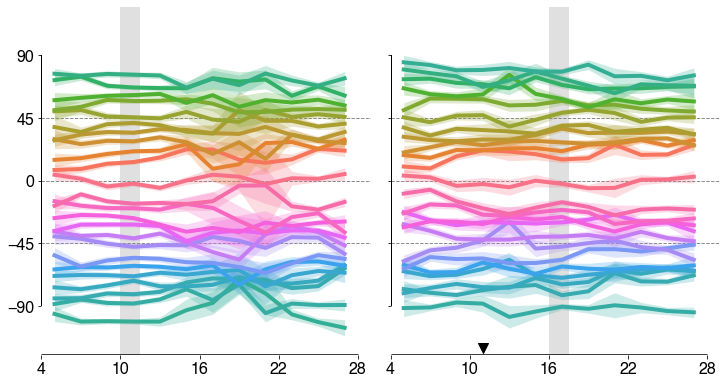

In [5]:
f, ax = plt.subplots(1,2,sharey=True)
utils.set_size([8,4.2])

ax[0].axvspan(10,11.5,color='darkgrey',alpha=0.35,linewidth=0,zorder=-3)
ax[1].axvspan(16,17.5,color='darkgrey',alpha=0.35,linewidth=0,zorder=-3)

for i_fig in range(2):
    for s in range(24):
        ax[i_fig].fill_between(np.arange(3,15)*2-1, 
                         stim_cond_boot_m[s,:,i_fig]-stim_cond_boot_es[s,:,i_fig], 
                         stim_cond_boot_m[s,:,i_fig]+stim_cond_boot_es[s,:,i_fig], 
                         color=utils.HUSL.colors[s], alpha=0.25, linewidth=0)
        ax[i_fig].plot(np.arange(3,15)*2-1, stim_cond_boot_m[s,:,i_fig], color=utils.HUSL.colors[s], linewidth=4)
    ax[i_fig].set_xlim([4,29])
    ax[i_fig].set_ylim([-125,125])
    ax[i_fig].axhline(y=0,   color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    ax[i_fig].axhline(y=45,  color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    ax[i_fig].axhline(y=-45, color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    utils.draw_publish_axis(ax[i_fig], xrange=(4,28), yrange=(-90,90), xticks=[4,10,16,22,28], yticks=[-90,-45,0,45,90])

if utils.LABEL:
    ax[0].set_xlabel(r"Time from trial onset (s)")    
    ax[1].set_xlabel(r"Time from trial onset (s)")    
    ax[0].set_ylabel(r"Reconstructed orientation $(\!\!^\circ\!\!)$", labelpad=0)
    ax[0].text(5,105,'Early',fontsize=18)
    ax[1].text(5,105,'Late',fontsize=18)
    
plt.scatter(11,-120, marker="v", color='k', s=100)
plt.savefig(f'{utils.DIR_FIGURE}/fig5a.pdf',bbox_inches='tight')
plt.show()    

+ Bias weight

In [6]:
# regression against the stimulus-specific bias function
sse_sim   = np.nan*np.empty((12,50,2))
stims_vec = np.arange(180,step=7.5)
for i_sub, v_sub in enumerate(np.unique(behavior.ID)):
    _ssb = utils.stimulus_specific_bias(stims_vec, ssb['weights'][v_sub], **ssb['info'])
    for i_t, v_t in enumerate([1,2]):
        for i_tr in range(12):            
            pattn = m_bold['indv_stim_cond'][i_tr,i_sub,:,i_t]*180/np.pi
            nonnan = ~np.isnan(pattn)
            reg = LinearRegression(fit_intercept=False).fit(_ssb[nonnan].reshape(-1,1),pattn[nonnan])
            sse_sim[i_tr,i_sub,i_t] = reg.coef_[0]

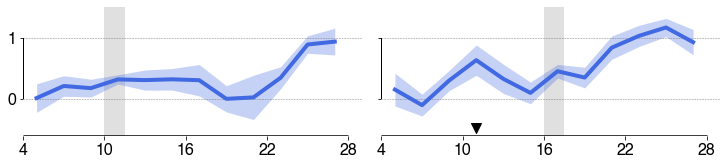

In [7]:
f, ax = plt.subplots(1,2, sharey=True)
utils.set_size([8,1.9])

ax[0].axvspan(10,11.5,color='darkgrey',alpha=0.35,linewidth=0,zorder=-3)
ax[1].axvspan(16,17.5,color='darkgrey',alpha=0.35,linewidth=0,zorder=-3)

for i_fig in range(2):
    mmm = np.mean(sse_sim[:,:,i_fig],axis=1)
    sss = np.std(sse_sim[:,:,i_fig],axis=1)/np.sqrt(50)
    ax[i_fig].axhline(y=0, color='gray', linestyle='dashed', linewidth=0.5)
    ax[i_fig].axhline(y=1, color='gray', linestyle='dashed', linewidth=0.5)
    ax[i_fig].plot(np.arange(3,15)*2-1, mmm, linewidth=4, color='#4169e1')
    ax[i_fig].fill_between(np.arange(3,15)*2-1, mmm-sss, mmm+sss, alpha=0.3, linewidth=0, color='#4169e1')
    ax[i_fig].set_ylim([-0.6,1.5])
    ax[i_fig].set_yticks([0,1])
    ax[i_fig].set_xlim([4,29])    
    utils.draw_publish_axis(ax[i_fig], xrange=(4,28), yrange=(0,1), xticks=[4,10,16,22,28], yticks=[0,1])

if utils.LABEL:
    ax[0].set_xlabel(r"Time from trial onset (s)")    
    ax[1].set_xlabel(r"Time from trial onset (s)")    
    ax[0].set_ylabel(r"Bias weight", labelpad=8)

plt.scatter(11,-0.48, marker="v", color='k', s=100)
plt.savefig(f'{utils.DIR_FIGURE}/fig5b.pdf',bbox_inches='tight')
plt.show()

In [8]:
ttest  = DescrStatsW(sse_sim[3,:,1])
wilcox = wilcoxon(sse_sim[3,:,1])
print("Bias weight at 11s after onset in late DM condition")
print('\nPaired samples t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

Bias weight at 11s after onset in late DM condition

Paired samples t-test
t(49)= 2.5428684861268063 p= 0.014203374881094561
95% CI= (0.13251398561723393, 1.1312021291560017)

Wilcoxon signed-rank test (without continuity correction)
V= 384.0 p= 0.014400842176559257


---

## Decision-consistent bias dynamics 

In [9]:
cutoff = np.quantile( (decision_cond_perm[:,:,0,:] - decision_cond_perm[:,:,1,:])*180/np.pi, 1-0.025/12, axis=-1 )
test   = ((m_bold['pop_decision_cond'][:,:,0] - m_bold['pop_decision_cond'][:,:,1])*180/np.pi > cutoff)*1

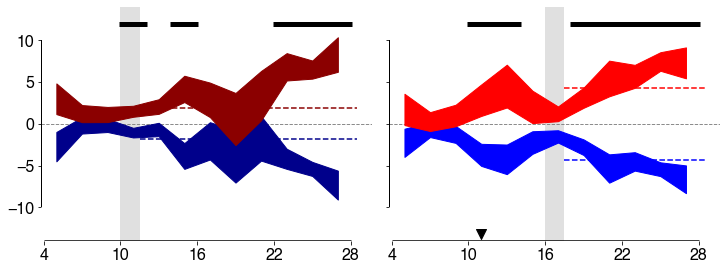

In [10]:
dm_cond_boot_m  = np.mean(decision_cond, axis=-1) * 180/np.pi
dm_cond_boot_se = np.std(decision_cond, axis=-1) * 180/np.pi

trs = np.arange(3,15)*2-1

f, ax = plt.subplots(1,2, sharey=True)
utils.set_size([8,3])
ax[0].axvspan(10,11.5,color='darkgrey',alpha=0.35,linewidth=0,zorder=-3)
ax[1].axvspan(16,17.5,color='darkgrey',alpha=0.35,linewidth=0,zorder=-3)

for i_fig in range(2):
    red = 'red' if i_fig==1 else 'darkred'
    blue = 'blue' if i_fig==1 else 'darkblue'
    ax[i_fig].axhline(y=0,   color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    ax[i_fig].fill_between(x=trs, y1=(dm_cond_boot_m-dm_cond_boot_se)[i_fig,:,1], y2=(dm_cond_boot_m+dm_cond_boot_se)[i_fig,:,1], color=blue)
    ax[i_fig].fill_between(x=trs, y1=(dm_cond_boot_m-dm_cond_boot_se)[i_fig,:,0], y2=(dm_cond_boot_m+dm_cond_boot_se)[i_fig,:,0], color=red)
    ax[i_fig].set_ylim([-14,14])
    for _t in range(12):
        if test[i_fig,_t] == 1:
            ax[i_fig].hlines(12, xmin=trs[_t]-1.1, xmax=trs[_t]+1.1, linewidth=5, color='black')
    ax[i_fig].hlines(y=[ dcb['pop'][0], dcb['pop'][1]][i_fig], xmin=[11.5,17.5][i_fig], xmax=28.5, color=red, linestyle='dashed', linewidth=1.5, zorder=0)
    ax[i_fig].hlines(y=[-dcb['pop'][0],-dcb['pop'][1]][i_fig], xmin=[11.5,17.5][i_fig], xmax=28.5, color=blue, linestyle='dashed', linewidth=1.5, zorder=0)
    utils.draw_publish_axis(ax[i_fig], xrange=(4,28), yrange=(-10,10), xticks=[4,10,16,22,28], yticks=[-10,-5,0,5,10])
    
if utils.LABEL:
    ax[0].set_xlabel(r"Time from trial onset (s)")    
    ax[1].set_xlabel(r"Time from trial onset (s)")    
    ax[0].set_ylabel(r"Reconstructed error $(\!\!^\circ\!\!)$", labelpad=0)
    
plt.scatter(11,-13.2, marker="v", color='k', s=100)
plt.savefig(f'{utils.DIR_FIGURE}/fig5c.pdf',bbox_inches='tight')
plt.show()